<h1 align="center"><font size="5">Evaluate Classification Methods and Algorithms</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [114]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [115]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Data From CSV File  

In [116]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [117]:
df.shape

(346, 10)

### Convert to date time object 

In [118]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [119]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [120]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

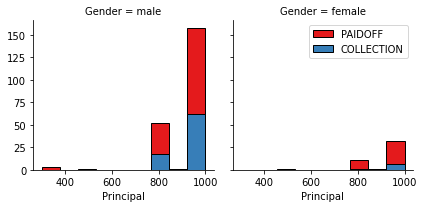

In [121]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

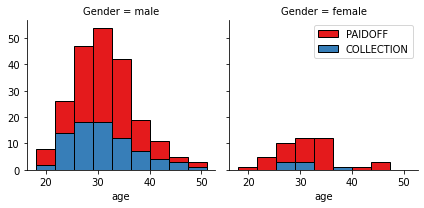

In [122]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

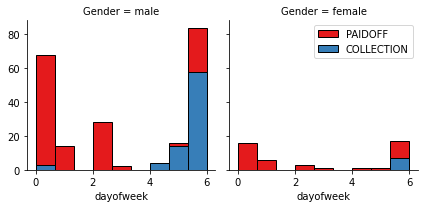

In [123]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [124]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [125]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [126]:
df['Gender'].replace(to_replace=['male', 'female'], value=[0 ,1],inplace=True)

## One Hot Encoding  
#### How about education?

In [127]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [128]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [129]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [130]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [131]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [132]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

#Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print()
print(X_train[0:5])

(276, 8) (70, 8) (276,) (70,)

[[ 0.51578458  0.92071769 -0.65321055 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [-1.31458942 -0.95911111  2.16570687  2.37778177  0.82934003 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769 -0.15575453 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [-1.31458942 -0.95911111 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.81902922  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]]


In [134]:
k=15
mean_acc = np.zeros((k-1))
std_acc=np.zeros((k-1))

for n in range(1,k):
    #Train Model and Predict 
    neig = KNeighborsClassifier(n_neighbors =n).fit(X_train, y_train)
    yhat = neig.predict(X_test)
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    #std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
print(neig)
print()
print(mean_acc)



KNeighborsClassifier(n_neighbors=14)

[0.65714286 0.57142857 0.7        0.67142857 0.71428571 0.68571429
 0.75714286 0.72857143 0.75714286 0.68571429 0.77142857 0.77142857
 0.8        0.75714286]


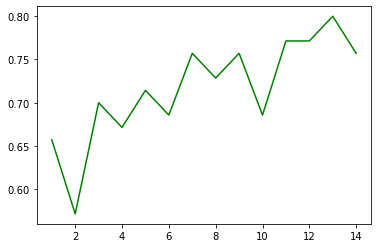

In [135]:
#Plot model accuracy for Different number of Neighbors

plt.plot(range(1,k),mean_acc,'g')           #)           , mean_train, 'b')

In [136]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8 with k= 13


In [137]:
print(confusion_matrix(y_test,yhat))

print(classification_report(y_test,yhat))

[[ 5  7]
 [10 48]]
              precision    recall  f1-score   support

  COLLECTION       0.33      0.42      0.37        12
     PAIDOFF       0.87      0.83      0.85        58

    accuracy                           0.76        70
   macro avg       0.60      0.62      0.61        70
weighted avg       0.78      0.76      0.77        70



In [138]:
yhat_prob = neig.predict_proba(X_test)
mean_test = accuracy_score(y_test, yhat)
mean_train = accuracy_score(y_train, neig.predict(X_train))
print(mean_test)
print(mean_train)

0.7571428571428571
0.7572463768115942


# Decision Tree

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [140]:
k=10
mean_dec = np.zeros((k-1))

for n in range(1,k):
    #Train Model and Predict 
    dectree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dectree.fit(X_train, y_train)
    yhat_dec = dectree.predict(X_test)
    mean_dec[n-1] = np.mean(yhat_dec==y_test)

mean_dec

array([0.82857143, 0.82857143, 0.82857143, 0.71428571, 0.8       ,
       0.72857143, 0.74285714, 0.72857143, 0.72857143])

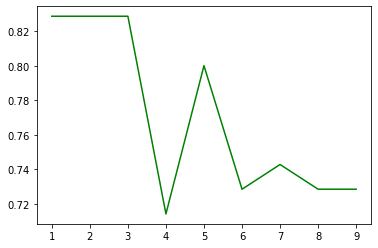

In [141]:
plt.plot(range(1,k),mean_dec,'g')

In [142]:
dec_acc = accuracy_score(y_test, yhat_dec)
print( "The best accuracy was at", mean_dec.max(), "and max_depth of 3+1 =4")
print()
print(classification_report(y_test, yhat_dec))

The best accuracy was at 0.8285714285714286 and max_depth of 3+1 =4

              precision    recall  f1-score   support

  COLLECTION       0.32      0.50      0.39        12
     PAIDOFF       0.88      0.78      0.83        58

    accuracy                           0.73        70
   macro avg       0.60      0.64      0.61        70
weighted avg       0.79      0.73      0.75        70



# Support Vector Machine

In [143]:
from sklearn import svm
clf_rbf = svm.SVC(kernel='rbf')
clf_pol = svm.SVC(kernel='poly')
clf_lin = svm.SVC(kernel='linear')
clf_rbf.fit(X_train, y_train)
clf_lin.fit(X_train, y_train)
clf_pol.fit(X_train, y_train)

SVC(kernel='poly')

In [144]:
#Train Model and Predict 
yhat_rbf = clf_rbf.predict(X_test)
svm_acc = accuracy_score(y_test, yhat_rbf)
svm_acc

0.7142857142857143

In [145]:
#Train Model and Predict 
yhat_lin = clf_lin.predict(X_test)
svm_acc = accuracy_score(y_test, yhat_lin)
svm_acc

0.8285714285714286

In [146]:
#Train Model and Predict 
yhat_pol = clf_lin.predict(X_test)
svm_acc = accuracy_score(y_test, yhat_pol)
svm_acc

0.8285714285714286

In [147]:
print(y_test)
print(yhat_rbf)
print(metrics.confusion_matrix(y_test, yhat_rbf))

['COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'

In [148]:
#from sklearn.metrics import jaccard_score
#jaccard_score(y_test, yhat_rbf)

#from sklearn.metrics import f1_score
#print(f1_score(y_test, yhat_rbf, average='weighted'))
print('ACCURACY_SCORE :\n');
print(metrics.accuracy_score(y_test, yhat_rbf))


ACCURACY_SCORE :

0.7142857142857143


In [149]:
#from sklearn.metrics import jaccard_similarity_score
#print(jaccard_similarity_score(y_test, yhat_lin))

#from sklearn.metrics import f1_score
#print(f1_score(y_test, yhat_lin, average='weighted'))


# Logistic Regression

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.005, solver='liblinear').fit(X_train,y_train)  #lbfgs
LR
LR.fit(X_train, y_train)
yhat_lr = LR.predict(X_test)
yhat_lrprob = LR.predict_proba(X_test)

In [151]:
#Train Model and Predict 
LR.fit(X_train, y_train)
yhat_lr = LR.predict(X_test)

#Predict probabilities
yhat_lrprob = LR.predict_proba(X_test)

In [152]:
print(confusion_matrix(y_test, yhat_lr))


[[ 4  8]
 [ 7 51]]


In [153]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_test, yhat_lr,average='weighted'))

from sklearn.metrics import log_loss
print(log_loss(y_test, yhat_lrprob))

print(classification_report(y_test, yhat_lr))

0.67634996582365
0.590535048736866
              precision    recall  f1-score   support

  COLLECTION       0.36      0.33      0.35        12
     PAIDOFF       0.86      0.88      0.87        58

    accuracy                           0.79        70
   macro avg       0.61      0.61      0.61        70
weighted avg       0.78      0.79      0.78        70



# Model Evaluation using Test set

In [154]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [155]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Test set for evaluation 

In [156]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [157]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [158]:
X = Feature_test


X_eval = preprocessing.StandardScaler().fit(X).transform(X)
X_eval[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [159]:
y_eval = test_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [160]:
neig_eval = KNeighborsClassifier(n_neighbors =7)
neig_eval.fit(X_train, y_train)
yhat_knn_eval = neig_eval.predict(X_eval)
    
dectree_eval = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dectree_eval.fit(X_train, y_train)
yhat_dec_eval = dectree_eval.predict(X_eval)

clf_lin_eval = svm.SVC(kernel='linear')
clf_lin_eval.fit(X_train, y_train)
yhat_svm_eval = clf_lin_eval.predict(X_eval)

LR_eval = LogisticRegression(C=0.005, solver='liblinear').fit(X_train,y_train)  #lbfgs
LR_eval.fit(X_train, y_train)
yhat_lr_eval = LR_eval.predict(X_eval)
#Predict probabilities
yhat_lr_prob = LR_eval.predict_proba(X_eval)

In [161]:
# KNN Model accuracy

knn_jac_eval = jaccard_score(y_eval, yhat_knn_eval, average='macro')
print("KNN Jaccard Score =", knn_jac_eval)
print()
print("KNN F1 Score is ",f1_score(y_eval, yhat_knn_eval, average='weighted'))


KNN Jaccard Score = 0.4552631578947368

KNN F1 Score is  0.7001989201477693


In [162]:
# Decision Tree Model accuracy
#print( "The best accuracy was with", dec_acc.max(), "with max_depth=", dectree.max_depth)

dec_jac_eval = jaccard_score(y_eval, yhat_dec_eval,average='macro')
print("Decision Trees's Jaccard Score is ",dec_jac_eval)
print()
print("Decision Tree's F1 Score is ",f1_score(y_eval, yhat_dec_eval, average='weighted'))
print()


Decision Trees's Jaccard Score is  0.5108695652173914

Decision Tree's F1 Score is  0.7302518270260205



In [163]:
# SVM Model accuracy
print("SVM's Jaccard Score is ", jaccard_score(y_eval, yhat_svm_eval,average='macro'))
print()
print("Logistic's F1 Score is ",f1_score(y_eval, yhat_svm_eval, average='weighted'))





SVM's Jaccard Score is  0.37037037037037035

Logistic's F1 Score is  0.6304176516942475


In [164]:
print("Logistic's Jaccard Score is ", jaccard_score(y_eval, yhat_lr_eval,average='weighted'))
print()
print("Logistic's Log Loss is ", log_loss(y_eval, yhat_lr_prob))
print()
print("Logistic's F1 Score is ",f1_score(y_eval, yhat_lr_eval, average='weighted'))
print()


list_ll = ['NA', 'NA', 'NA',(log_loss(y_eval, yhat_lr_prob))]
list_ll

Logistic's Jaccard Score is  0.5775681341719078

Logistic's Log Loss is  0.6141685694076249

Logistic's F1 Score is  0.6717642373556352



['NA', 'NA', 'NA', 0.6141685694076249]

In [165]:
# evaluate KNN
knn_yhat = neig.predict(X_test)
jc1 = (jaccard_score(y_test, knn_yhat,average='weighted'))

# evaluate Decision Trees
dt_yhat = dectree.predict(X_test)
jc2 = (jaccard_score(y_test, dt_yhat,average='weighted'))

#evaluate SVM
svm_yhat = clf_lin_eval.predict(X_test)
jc3 = (jaccard_score(y_test, svm_yhat,average='weighted'))
# evaluate Logistic Regression
lr_yhat = LR_eval.predict(X_test)
jc4 = (jaccard_score(y_test, lr_yhat,average='weighted'))

list_jc = [jc1, jc2, jc3, jc4]
list_jc

[0.6508291708291709, 0.6237321428571428, 0.686530612244898, 0.67634996582365]

In [166]:
# evaluate KNN
fs1 = (f1_score(y_eval, yhat_knn_eval,average='weighted'))
# evaluate Desision Trees 
fs2 = (f1_score(y_eval, yhat_dec_eval, average='weighted'))
# evaluate SVM
fs3 = (f1_score(y_eval, yhat_svm_eval, average='weighted'))
# evaluate Logistic Regression
fs4 = (f1_score(y_eval, yhat_lr_eval, average='weighted'))

list_fs = [fs1, fs2, fs3, fs4]
list_fs

[0.7001989201477693,
 0.7302518270260205,
 0.6304176516942475,
 0.6717642373556352]

# Report
###  The accuracy of the built model using different evaluation metrics:

In [167]:
# fomulate the report format
df = pd.DataFrame( list_jc,index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.650829,0.700199,NA
Decision Tree,0.623732,0.730252,NA
SVM,0.686531,0.630418,NA
Logistic Regression,0.676350,0.671764,0.614169
